In [1]:
from typing_extensions import TypedDict
from typing import List
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel

llm = init_chat_model("openai:gpt-4o")


def wrap_prompt(prompt:str):
    PROMPT_LANG = "\nAnswer only in fluent and natural Korean, no matter the input language."
    return f"{prompt} {PROMPT_LANG}"


In [ ]:
class State(TypedDict):

    dish: str
    dish_name: str
    ingredients: list[dict]
    recipe_steps: str
    plating_instructions: str

class Ingredient(BaseModel):
    name: str
    quantity: str
    unit: str

class IngredientsOutput(BaseModel):
    ingredients: List[Ingredient]



In [3]:
# nodes

def list_ingredients(state:State):
    structured_llm = llm.with_structured_output(IngredientsOutput)      # llm의 출력 포멧을 지정
    response = structured_llm.invoke(wrap_prompt(f"List 3-6 ingredients needed to make {state['dish']}"))

    
    return {
        "ingredients": response.ingredients
        }

def create_recipe(state:State):
    response = llm.invoke(wrap_prompt(f"Write a step by step cooking instruction for {state['dish']}, using these ingredients: {state['ingredients']}"))
    return {
        "recipe_steps": response.content
    }

def describe_plating(state:State):
    response = llm.invoke(wrap_prompt(f"Describe how to beautifully plate {state['dish']} based on this recipe: {state['recipe_steps']}"))
    return {
        "plating_instructions": response.content
    }

def gate(state:State):
    ingredients = state["ingredients"]
    if len(ingredients) > 6 or len(ingredients) < 3:
        return False
    else:
        return True

def create_dish_name(state:State):
    response = llm.invoke(wrap_prompt(f"당신은 요리 이름을 추천해주는 전문가 입니다. 요리의 이름은 직관적이고 사람들이 부르기 쉬워야 하며 너무 길지 않아야 합니다. 주어진 정보를 기반으로 창의적인 이름을 제안해주세요. 주어진 정보는 다음과 같습니다. 요리 이름: {state['dish']}, 요리 재료: {state['ingredients']}, 요리 조리 방법: {state['recipe_steps']}, 요리 그릇 배치 방법: {state['plating_instructions']}"))
    return {
        "dish_name": response.content
    }



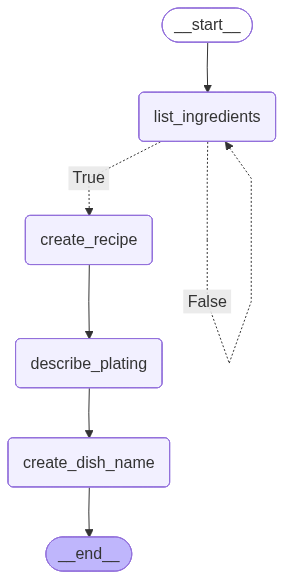

In [4]:
graph_builder = StateGraph(State)

graph_builder.add_node("list_ingredients", list_ingredients)
graph_builder.add_node("create_recipe", create_recipe)
graph_builder.add_node("describe_plating", describe_plating)
graph_builder.add_node("create_dish_name", create_dish_name)

graph_builder.add_edge(START, "list_ingredients")
graph_builder.add_conditional_edges(
    "list_ingredients",
    gate,
    {
        True: "create_recipe",
        False: "list_ingredients"
    }
)
graph_builder.add_edge("create_recipe", "describe_plating")
graph_builder.add_edge("describe_plating", "create_dish_name")
graph_builder.add_edge("create_dish_name", END)

graph = graph_builder.compile()

graph

In [5]:
result = graph.invoke(
    {
        "dish": "자취생 한끼 식사용 간단한 조리법을 가진 고단백 요리",        
    }
)


In [6]:
result

{'dish': '자취생 한끼 식사용 간단한 조리법을 가진 고단백 요리',
 'dish_name': '이 요리는 자취생을 위한 간단하고 고단백인 요리라는 점을 고려하여 이름을 지어보겠습니다. "단백한끼 스파게티"는 어떨까요? "단백한끼"라는 이름은 \'단백질 가득한 한 끼\'라는 의미를 담고 있어, 요리의 특징을 잘 나타내며 부르기도 쉽습니다.',
 'ingredients': [Ingredient(name='닭가슴살', quantity='2', unit='조각'),
  Ingredient(name='달걀', quantity='2', unit='개'),
  Ingredient(name='양파', quantity='1', unit='개'),
  Ingredient(name='마늘', quantity='3', unit='쪽'),
  Ingredient(name='스파게티 국수', quantity='200', unit='그램'),
  Ingredient(name='올리브유', quantity='2', unit='큰술')],
 'recipe_steps': '자취생을 위한 간단하고 고단백인 닭가슴살 스파게티 조리법을 소개하겠습니다. 다음 단계를 따라 만들어 보세요.\n\n1. **재료 준비하기**  \n   - 닭가슴살 2조각을 먹기 좋은 크기로 깍둑썰기 합니다.\n   - 양파 1개는 얇게 채썰고, 마늘 3쪽은 다집니다.\n   - 달걀 2개는 미리 깨서 풀어 놓습니다.\n\n2. **스파게티 삶기**  \n   - 냄비에 물을 가득 채우고 소금을 적당량 넣은 후, 물이 끓으면 스파게티 국수 200그램을 넣고 8~10분간 삶습니다.\n   - 국수를 삶는 동안 중간에 저어주어 달라붙지 않도록 합니다.\n   - 국수가 다 삶아지면 찬물에 헹구어 체에 받쳐 놓습니다.\n\n3. **닭가슴살 익히기**  \n   - 큰 팬에 올리브유 1큰술을 두르고 중간 불로 달군 후, 닭가슴살을 넣어 익힙니다.\n   - 닭가슴살이 겉이 노릇노릇해질 때까지 약 5분 정도 익힙니다.\n\